In [8]:
import importlib
import utils
importlib.reload(utils)
from utils import *

In [7]:
img_fp = r'D:\PAKHUIYING\Image_processing\F3_raw_images\non_glint\2021_11_10_1_DNN_rgb_image_line_10_18333_19667.tif'
img = np.asarray(PIL.Image.open(img_fp))
img.shape

(1024, 9358, 3)

In [9]:
cut_img_list = cut_into_512(img)
len(cut_img_list)

38

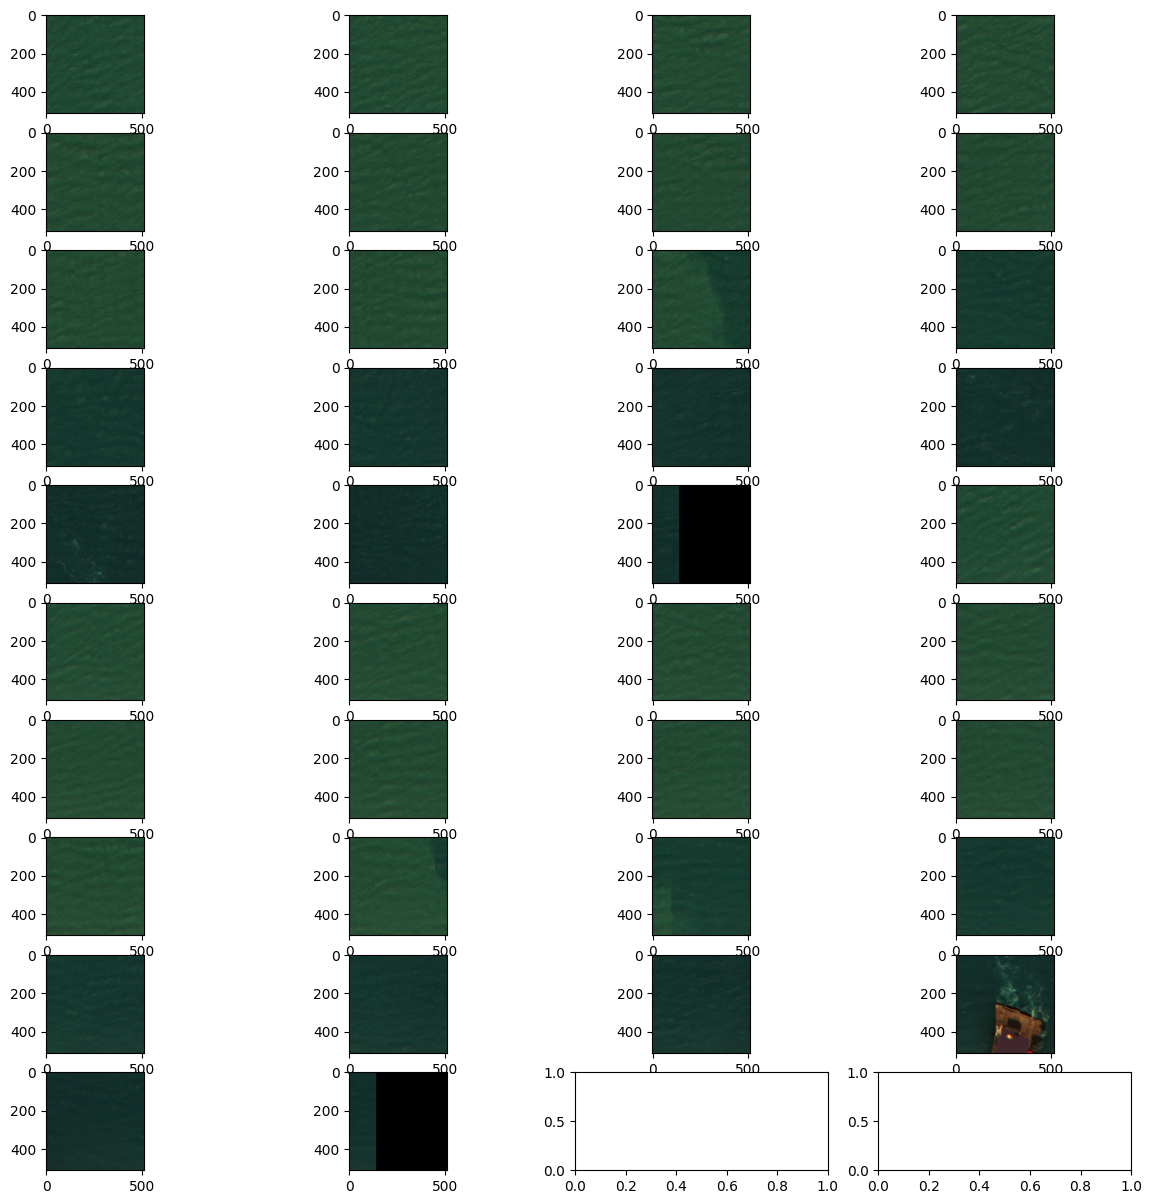

In [10]:
preview_cut_img(cut_img_list)

In [11]:
clean_img = cut_img_list[0]

In [ ]:
def calc_pfresnel(w,n_sw=1.34):
    """
    Calculate the fresnel reflection of sunglint at the water's surface
    Parameters
    ----------
    w : float or numpy.ndarray (np.float32/64)
        Angle of incidence of a light ray at the water surface (radians)
    n_sw : float
        Refractive index of sea-water (wavelength independent)
    Returns
    -------
    p_fresnel : numpy.ndarray (np.float32/64)
        The fresnel reflectance
    #####################
    Credits: https://github.com/GeoscienceAustralia/sun-glint-correction/blob/develop/sungc/algorithms.py
    #####################
    """
    w_pr = np.asin(np.sin(w)/n_sw)
    p_fres = 0.5*((np.sin(w-w_pr)/np.sin(w+w_pr))**2 + (np.tan(w-w_pr)/np.tan(w+w_pr))**2)

    return p_fres

def coxmunk_backend(view_zenith,solar_zenith,relative_azimuth,wind_speed,return_fresnel=False):
    """
    Estimates the wavelength-independent sunglint reflectance using the
    Cox and Munk (1954) algorithm. Here the wind direction is not taken
    into account.
    Parameters
    ----------
    view_zenith : np.ndarray
        sensor view-zenith angle image
        (units of image data: degrees)
    solar_zenith : np.ndarray
        solar zenith angle image
        (units of image data: degrees)
    relative_azimuth : np.ndarray
        relative azimuth angle between sensor and sun image
        image (units of image data: degrees)
    wind_speed : float
        Wind speed (m/s)
    return_fresnel : bool
        Return fresnel reflectance array
    Returns
    -------
    p_glint : numpy.ndarray (np.float32/64)
        Estimated sunglint reflectance
    p_fresnel : None or numpy.ndarray (np.float32/64)
        Fresnel reflectance of sunglint. Useful for debugging
        if return_fresnel=False then p_fresnel=None
        if return_fresnel=True  then p_fresnel=numpy.ndarray
    Raises
    ------
    ValueError:
        * if input arrays are not two-dimensional
        * if dimension mismatch
        * if wind_speed < 0
    #####################
    Credits: https://github.com/GeoscienceAustralia/sun-glint-correction/blob/develop/sungc/algorithms.py
    #####################
    """
    
